In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICE'] = ''
import random

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch

%load_ext autoreload
%autoreload 2

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.data.iam_paragraphs import IAMParagraphs
from text_recognizer.data.iam_synthetic_paragraphs import IAMSyntheticParagraphs
from text_recognizer.data.iam_extended_paragraphs import IAMExtendedParagraphs

In [2]:
def _plot(image, figsize=(12,12), title='', vmin=0, vmax=255):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)

def convert_y_label_to_string(y, mapping, padding_index=3):
    return ''.join([mapping[int(i)] for i in y if i != padding_index])

In [3]:
from hydra import compose, initialize
from omegaconf import OmegaConf
from hydra.utils import instantiate

In [4]:
# context initialization
with initialize(config_path="../training/conf/"):
    cfg = compose(config_name="config", overrides=["+experiment=conv_transformer_paragraphs"])

/tmp/ipykernel_13115/42406231.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../training/conf/"):


In [5]:
cfg.datamodule.pin_memory = False

In [6]:
datamodule = instantiate(cfg.datamodule)
datamodule.prepare_data()
datamodule.setup()
print(datamodule)

/home/aktersnurra/.cache/pypoetry/virtualenvs/text-recognizer-ejNaVa9M-py3.9/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
/home/aktersnurra/.cache/pypoetry/virtualenvs/text-recognizer-ejNaVa9M-py3.9/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
2022-06-20 00:26:31.034 | INFO     | text_recognizer.data.iam_paragraphs:setup:111 - Loading IAM paragraph regions and lines for None...
2022-06-20 00:26:45.099 | DEBUG    | text_recognizer.data.transforms.load_transform:_load_config:17 - Loading transforms from config: transfo

IAM Original and Synthetic Paragraphs Dataset
Num classes: 58
Dims: (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 20148, 66, 231
Train Batch x stats: (torch.Size([8, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0132), tensor(0.0661), tensor(1.))
Train Batch y stats: (torch.Size([8, 682]), torch.int64, tensor(1), tensor(57))
Test Batch x stats: (torch.Size([8, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0315), tensor(0.0799), tensor(0.9098))
Test Batch y stats: (torch.Size([8, 682]), torch.int64, tensor(1), tensor(57))



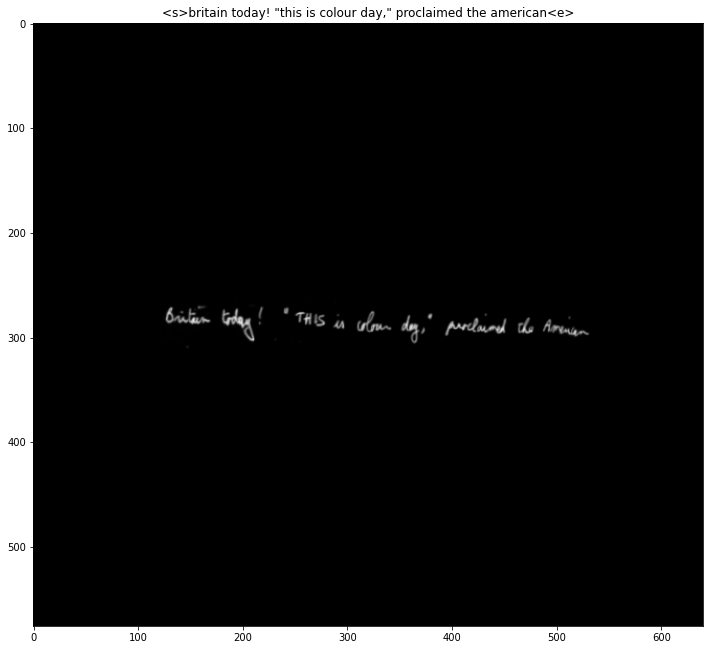

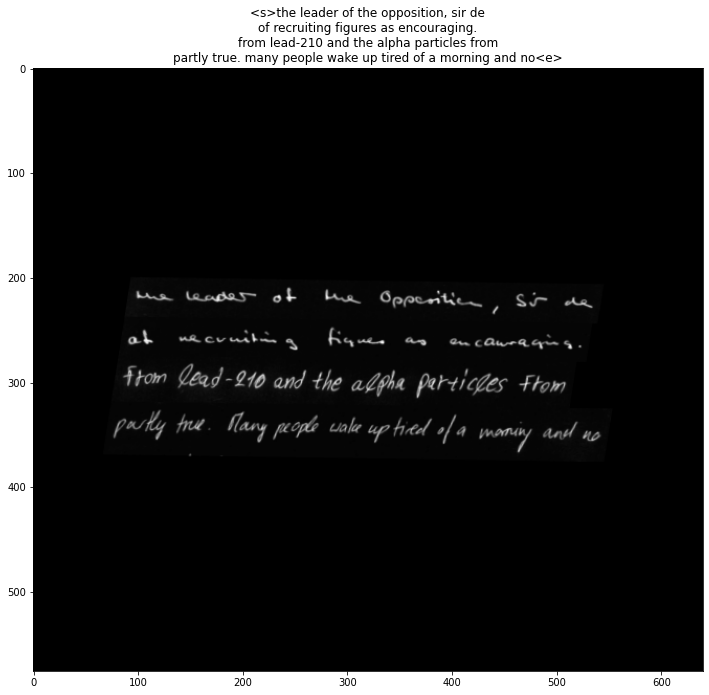

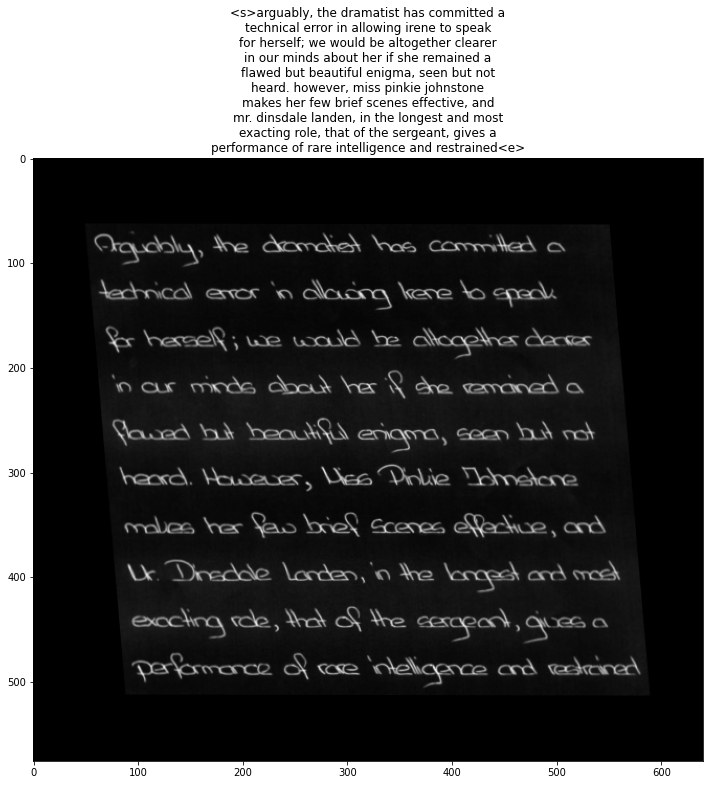

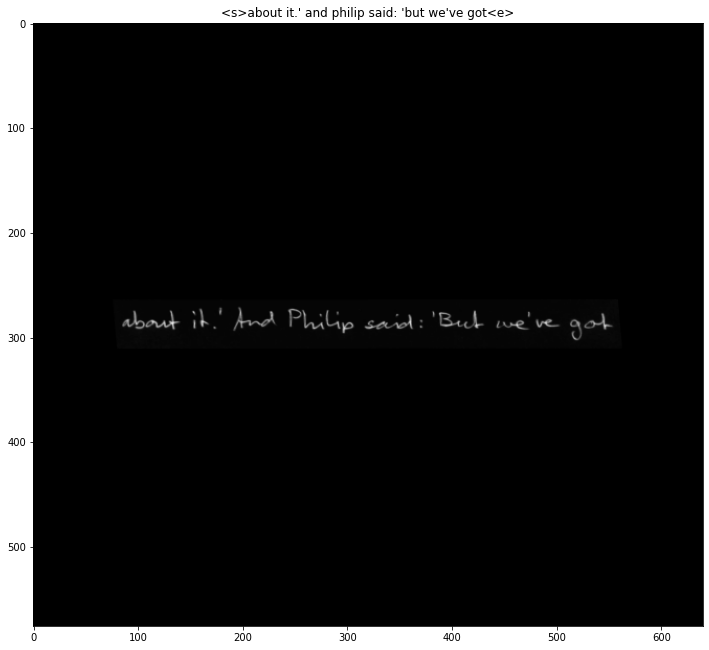

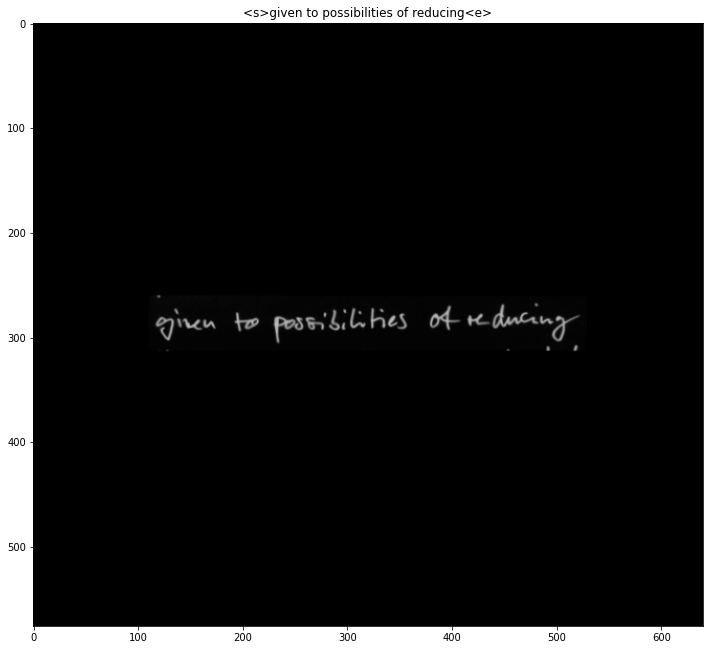

In [10]:
# Training
dataset = datamodule.data_train
for _ in range(5):
    i = random.randint(0, len(dataset))
    x, y = dataset[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, datamodule.mapping))

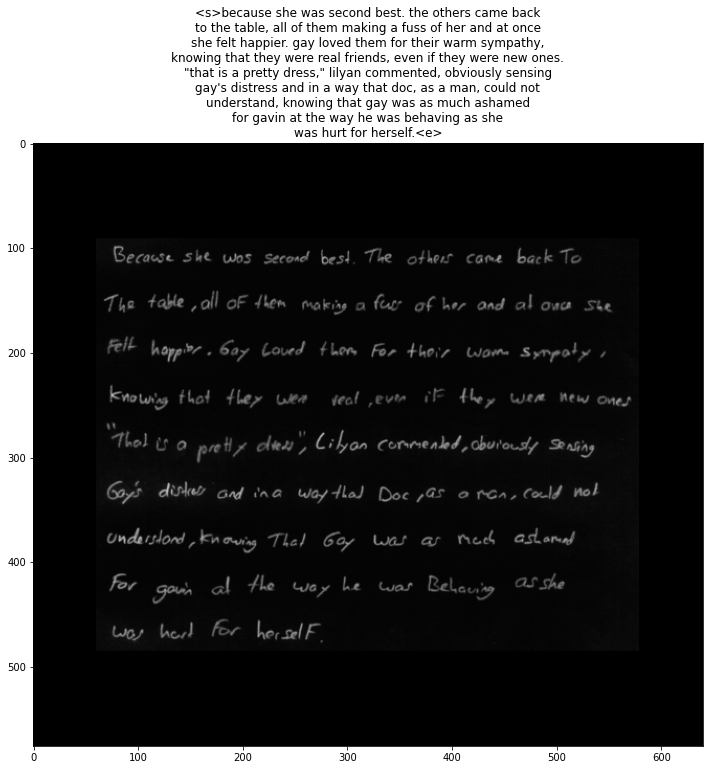

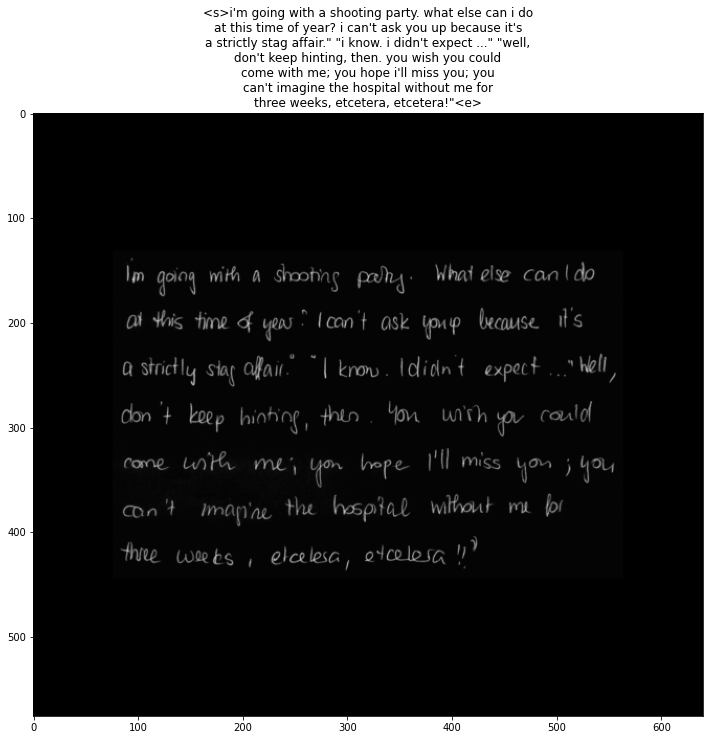

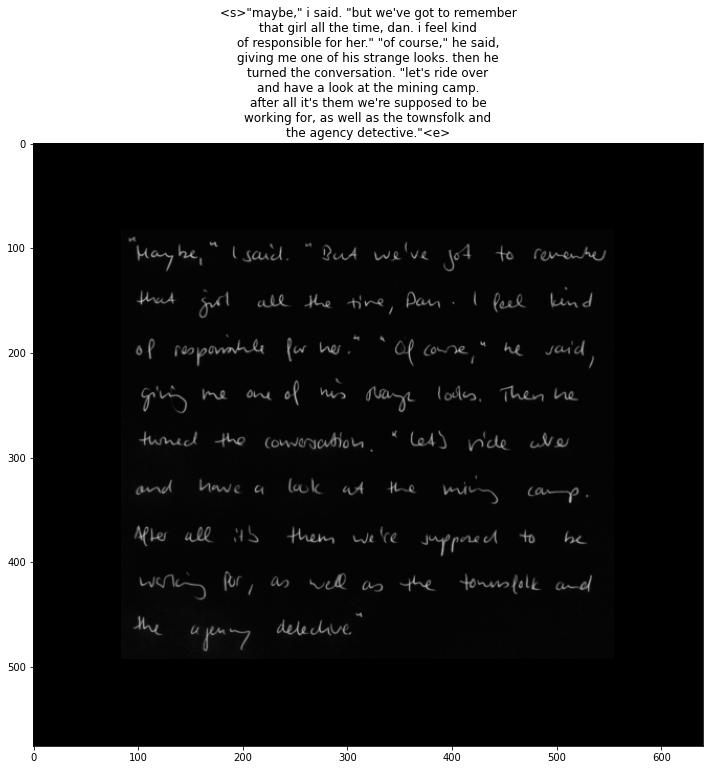

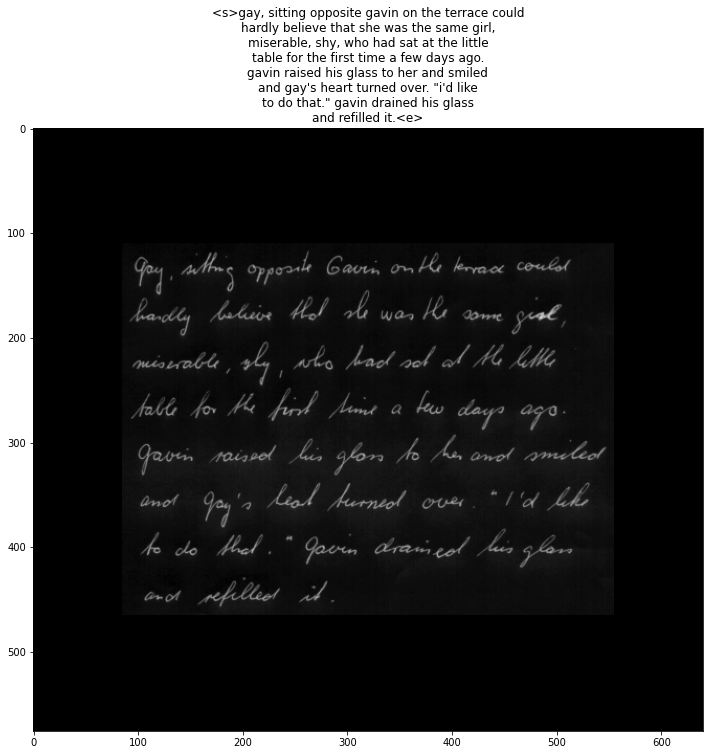

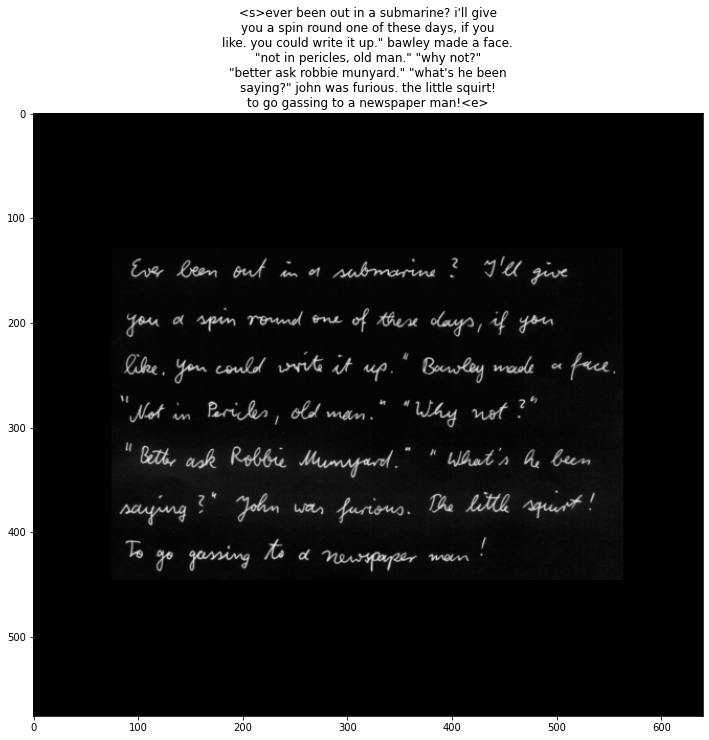

In [12]:
# Testing
dataset = datamodule.data_test
for _ in range(5):
    i = random.randint(0, len(dataset))
    x, y = dataset[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, datamodule.mapping))

In [13]:
x, y = dataset[0]

In [14]:
from einops.layers.torch import Rearrange

In [46]:
patch_height = patch_width = 8
channels = 1

In [47]:
fn = Rearrange(
                "b c (h p1) (w p2) -> b (h w) c p1 p2",
                p1=patch_height,
                p2=patch_width,
                c=channels,
            )

In [48]:
xx = fn(x.unsqueeze(0))

In [49]:
xx.shape

torch.Size([1, 5760, 1, 8, 8])

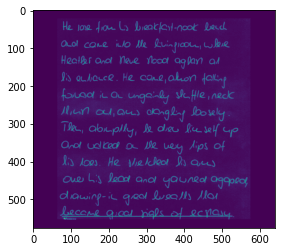

In [50]:
plt.imshow(x[0])

In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(15,15))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [52]:
from torchvision.utils import make_grid

In [53]:
xx.shape

torch.Size([1, 5760, 1, 8, 8])

In [54]:
640 / patch_height

80.0

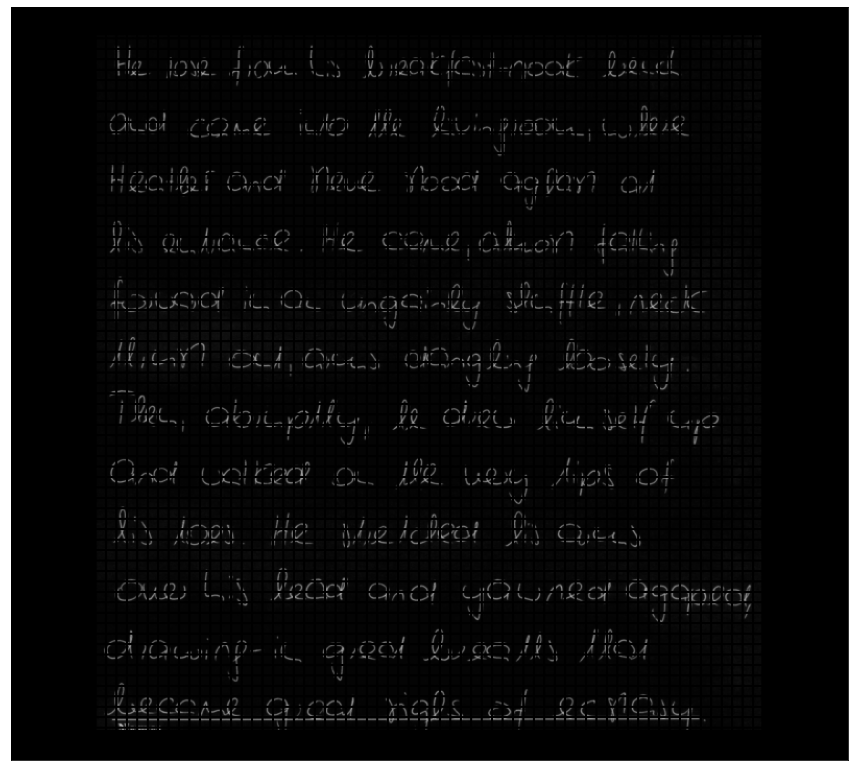

In [55]:
grid = make_grid(xx[0], nrow=80)
show(grid)

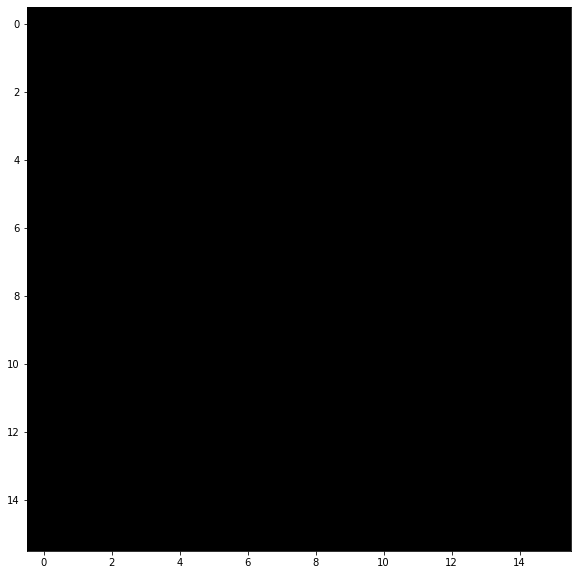

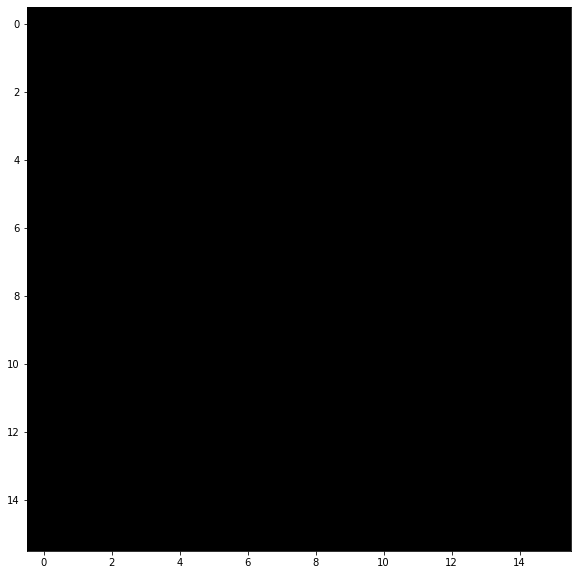

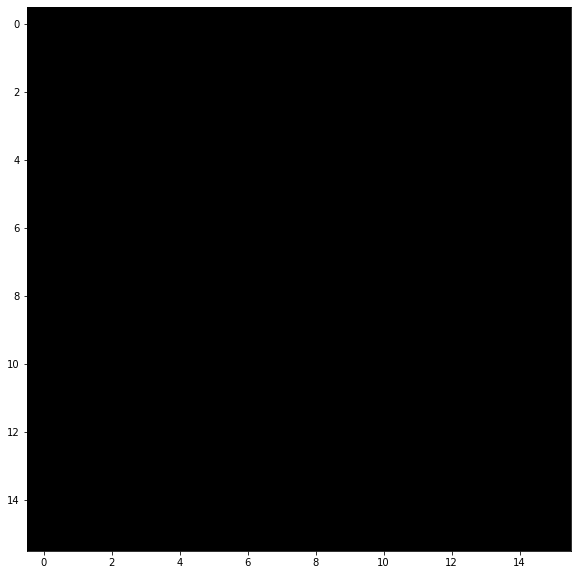

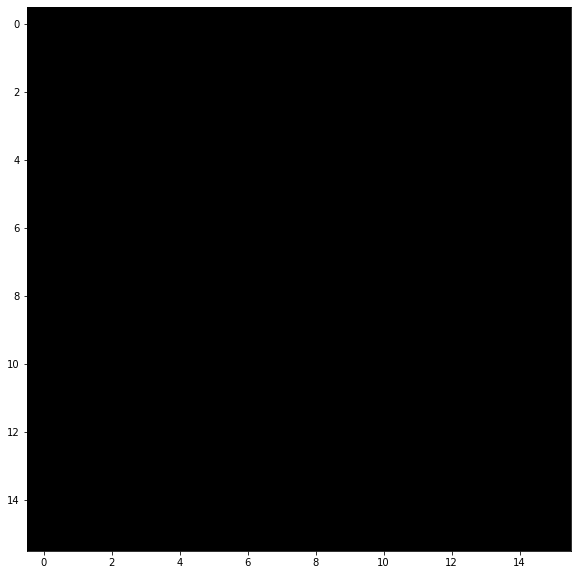

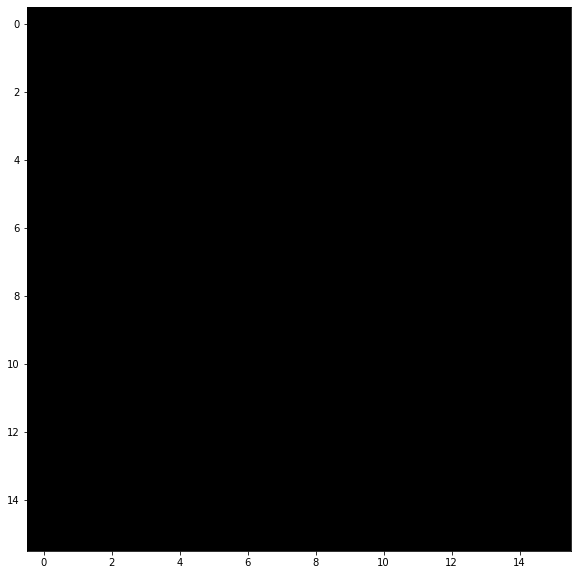

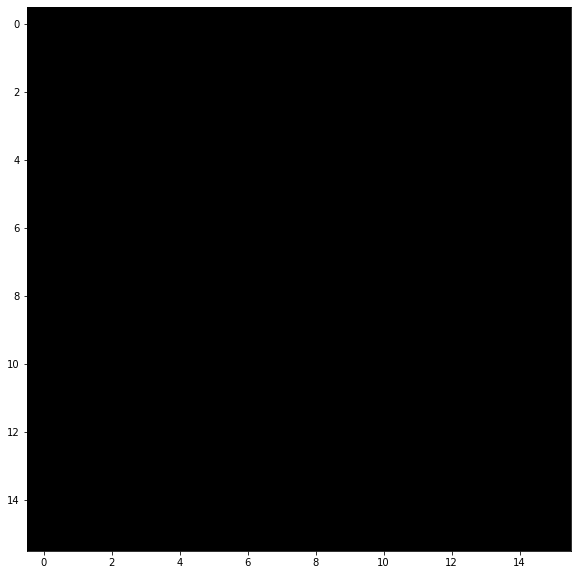

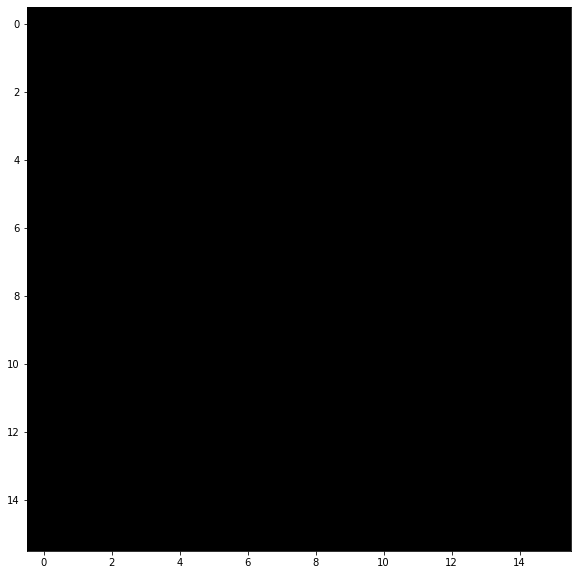

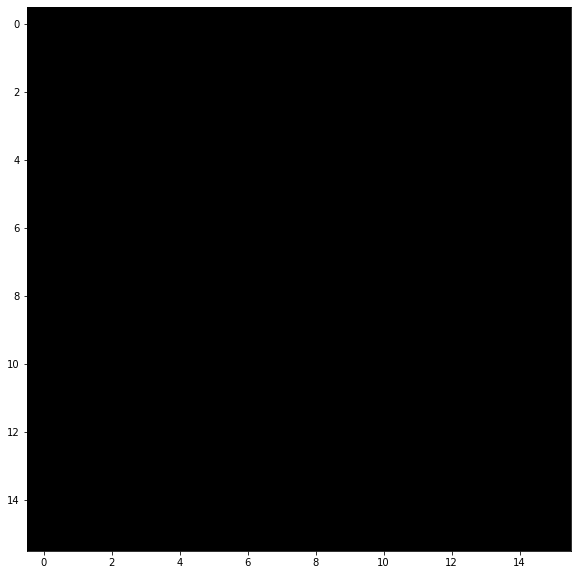

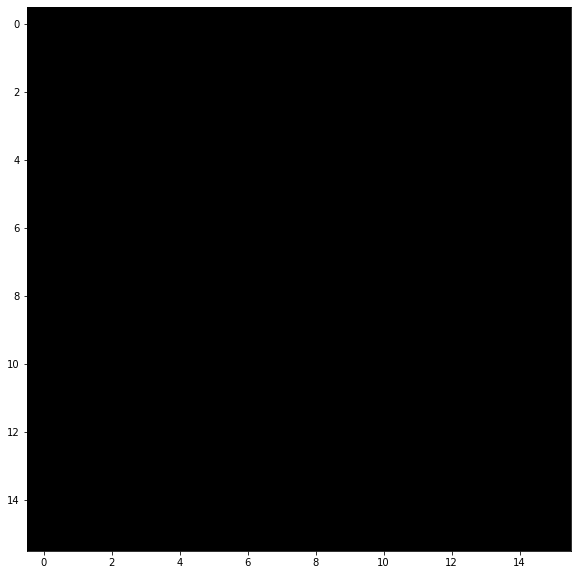

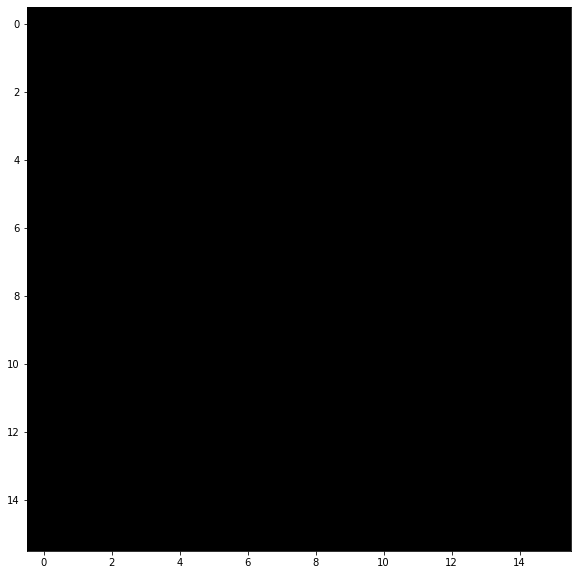

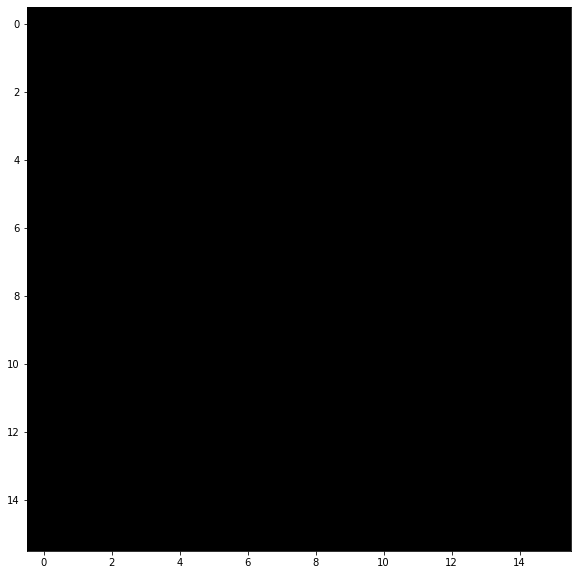

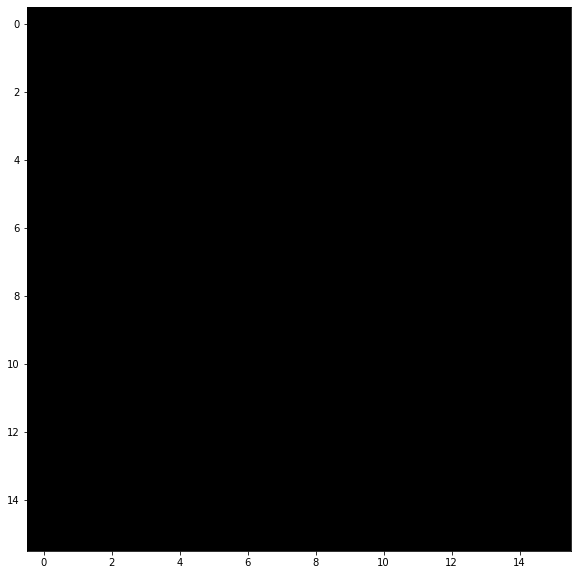

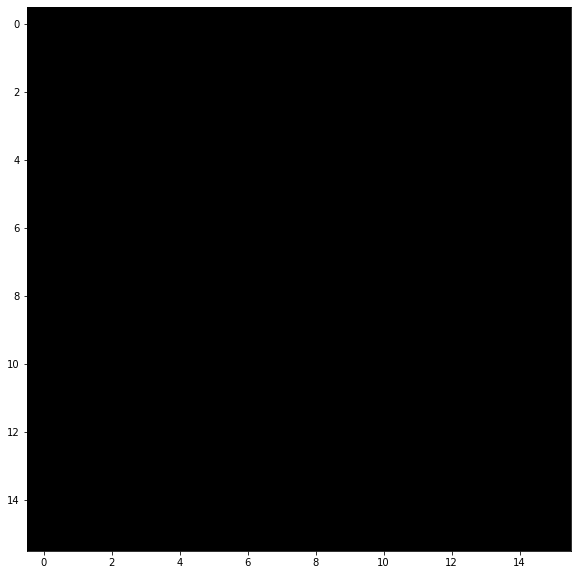

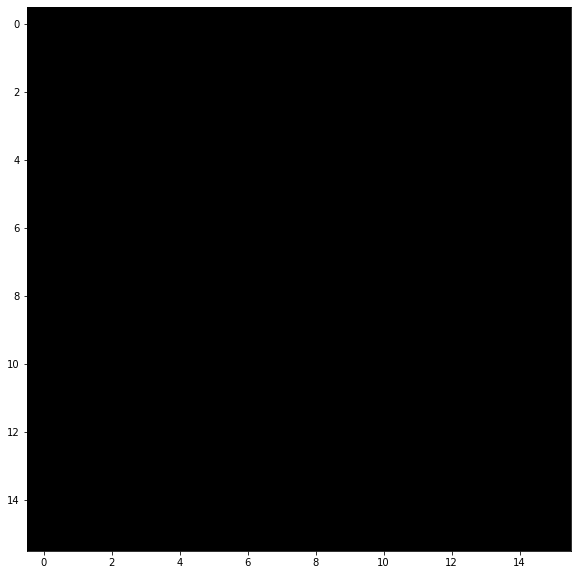

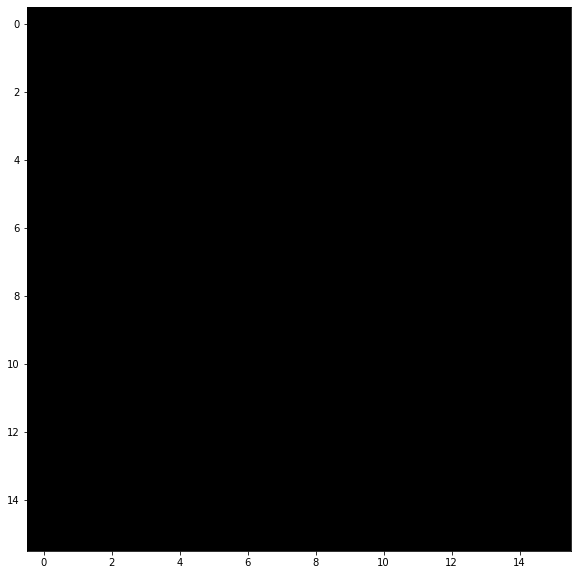

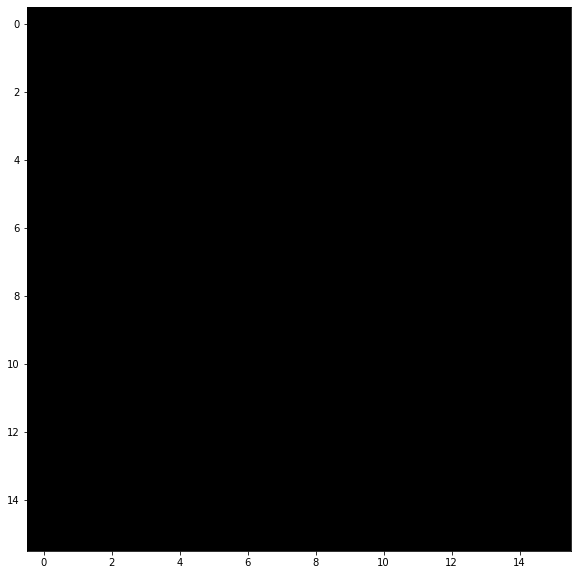

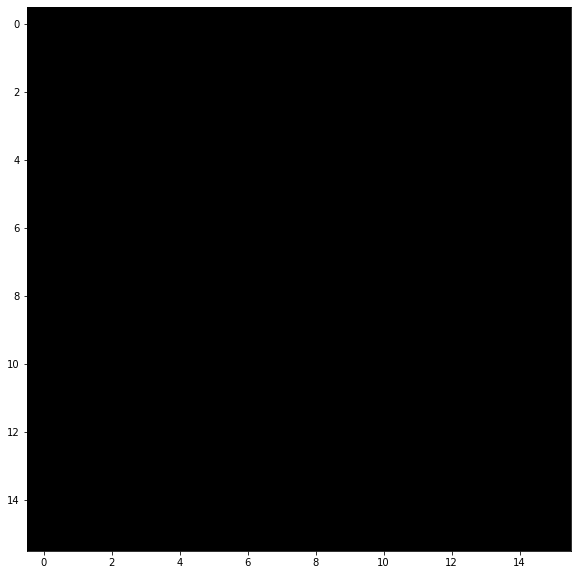

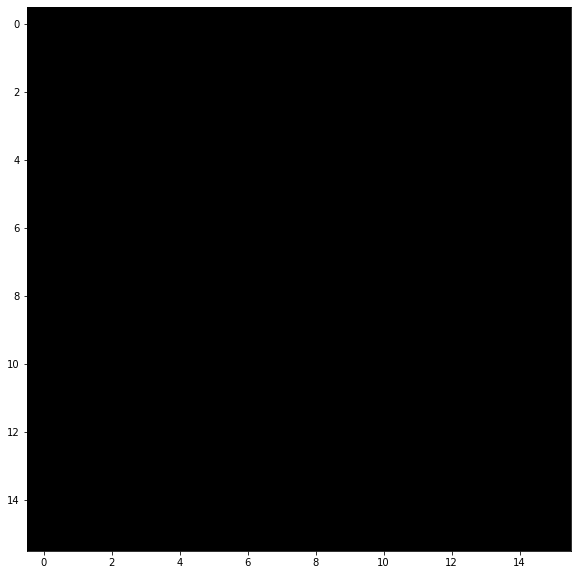

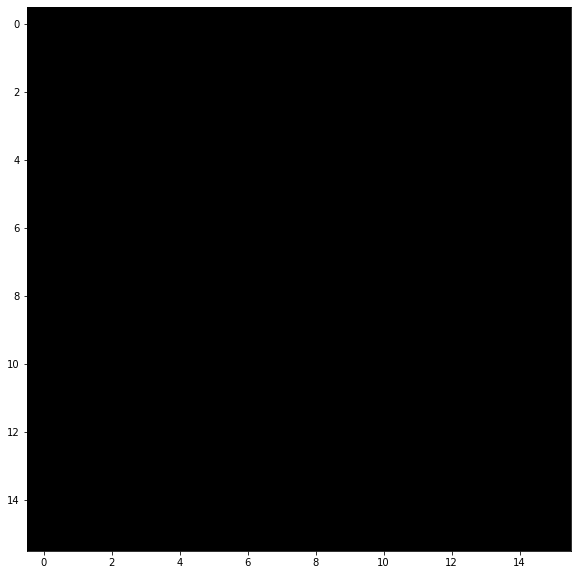

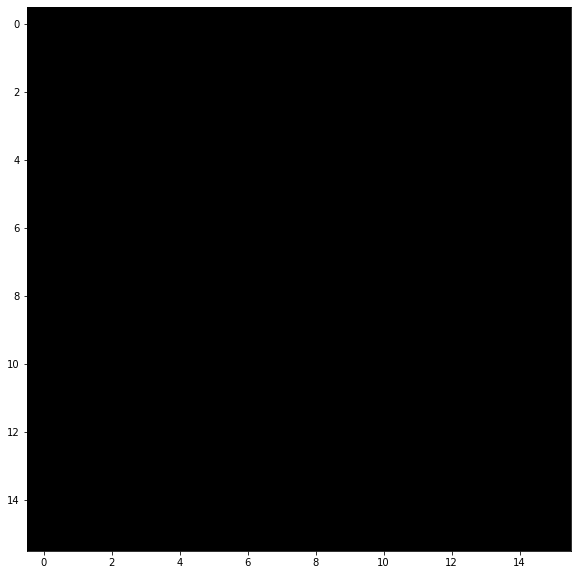

In [15]:
for _ in range(1320, 1340):
    plt.figure(figsize=(10, 10))
    plt.imshow(xx[0, 0, _], cmap="gray", vmin=0, vmax=255)